In [1]:
# import relevant modules
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
import time
import sys
%matplotlib inline

from scipy.special import hyp1f1
from dipy.core.sphere import disperse_charges, HemiSphere
from dipy.core.gradients import gradient_table
from dipy.sims.voxel import multi_tensor
import dipy.reconst.dti as dti
import dipy.reconst.dki as dki

from dipy.sims.voxel import (multi_tensor, _add_gaussian, _add_rician,
                             _add_rayleigh)

from pca_utils import (rfiw_phantom, mp_distribution,
                       fiber_segments_phantom, evaluate_directions,
                       evaluate_metric, pca_noise_classifier,
                       pca_denoising)

from dki_alternative import wls_fit_dki

Usefull Rician tools

In [2]:
def _normalized_rician_expected_value(snr):
    """
    Computes the rician expected intensity normalized by the
    noise standard deviation given the signal ground truth.

    Parameters
    ----------
    signal : array
        Containing ground truth signal to convert to expected values
    sigma : float or array
        Containing ground truth sigma

    Returns
    -------
    esignal : array
       Rician expected values for the given ground truth signals
    """
    return np.sqrt(0.5*np.pi) * hyp1f1(-0.5, 1.0, -0.5*(snr)**2)

def add_rician_bias(dwi, sigma):
    """ Add rician bias of a noise free data given a noise std value

    Parameters
    ----------
    dwi : array
        Matrix containing the noise free data.
    sigma : float
        Estimate of the noise std

    Returns
    -------
    dwib : array ([X, Y, Z, g])
        Matrix containing the biased version of the 4D data.
    """
    snr = dwi.copy() / sigma
    return sigma * _normalized_rician_expected_value(snr)

In [3]:
# ---------------------------------------------------------------
# acquisition parameters
# ---------------------------------------------------------------

acquisition = 0

if acquisition == 0:

    # Sample 8 diffusion-weighted directions for first shell
    n_pts = 8
    theta = np.pi * np.random.rand(n_pts)
    phi = 2 * np.pi * np.random.rand(n_pts)
    hsph_initial = HemiSphere(theta=theta, phi=phi)
    hsph_updated, potential = disperse_charges(hsph_initial, 5000)
    directions8 = hsph_updated.vertices  # directions for each shell

    # Sample 30 diffusion-weighted directions for second shell
    n_pts = 30
    theta = np.pi * np.random.rand(n_pts)
    phi = 2 * np.pi * np.random.rand(n_pts)
    hsph_initial = HemiSphere(theta=theta, phi=phi)
    hsph_updated, potential = disperse_charges(hsph_initial, 5000)
    directions30 = hsph_updated.vertices  # directions for each shell

    # Sample 60 diffusion-weighted directions for second shell
    n_pts = 60
    theta = np.pi * np.random.rand(n_pts)
    phi = 2 * np.pi * np.random.rand(n_pts)
    hsph_initial = HemiSphere(theta=theta, phi=phi)
    hsph_updated, potential = disperse_charges(hsph_initial, 5000)
    directions60 = hsph_updated.vertices  # directions for each shell

    # Create full dataset parameters
    bvals = np.hstack((np.zeros(6), 300 * np.ones(8),
                       1000 * np.ones(30), 2000 * np.ones(60)))
    bvecs = np.vstack((np.zeros((6, 3)), directions8, directions30, directions60))
    gtab = gradient_table(bvals, bvecs)
    
else:
    # Sample 30 diffusion-weighted directions for second shell
    n_pts = 30
    theta = np.pi * np.random.rand(n_pts)
    phi = 2 * np.pi * np.random.rand(n_pts)
    hsph_initial = HemiSphere(theta=theta, phi=phi)
    hsph_updated, potential = disperse_charges(hsph_initial, 50000)
    directions30 = hsph_updated.vertices  # directions for each shell

    # Create full dataset parameters
    bvals = np.hstack((np.zeros(6), 1000 * np.ones(30), 2000 * np.ones(30)))
    bvecs = np.vstack((np.zeros((6, 3)), directions30, directions30))
    gtab = gradient_table(bvals, bvecs)

In [4]:
dtiM = dti.TensorModel(gtab, fit_method='WLS')
dkiM = dki.DiffusionKurtosisModel(gtab, fit_method='WLS')

Compute ground truth values of MK

In [5]:
#gain measured in test_overcomplete_gain for snr 15, fsigma = 20 and acquisition squeme 0
gain = np.hstack((5.6198*np.ones(6), 5.2301*np.ones(8), 3.9605*np.ones(30), 3.1407**np.ones(60)))
p = 2
fsigmas = np.array([40.0, 30.0, 20.0, 10.0])
snr = 15
sigma = 50.0 /snr

Phantom = fiber_segments_phantom(gtab, fsigmas[p])

dtiFgt = dtiM.fit(Phantom)
DTI_FAgt = dtiFgt.fa
DTI_MDgt = dtiFgt.md

dkiFgt = dkiM.fit(Phantom)
DKI_FAgt = dkiFgt.fa
DKI_MDgt = dkiFgt.md
DKI_MKgt = dkiFgt.mk() 

print np.mean(DKI_MKgt[2:-2, 2:-2, 2:-2])

Phantom_rician = add_rician_bias(Phantom.copy(), sigma)

dtiFgt = dtiM.fit(Phantom_rician)
DTI_FAgt_rician = dtiFgt.fa
DTI_MDgt_rician = dtiFgt.md

dkiFgt = dkiM.fit(Phantom_rician)
DKI_FAgt_rician = dkiFgt.fa
DKI_MDgt_rician = dkiFgt.md
DKI_MKgt_rician = dkiFgt.mk() 

print np.mean(DKI_MKgt_rician[2:-2, 2:-2, 2:-2])

1.42411611539
1.45958789327


Run simulations

In [7]:
# initialize
fsigmas = np.array([40.0, 30.0, 20.0, 10.0])

nrep = 100

dir1 = np.zeros((fsigmas.size, nrep))

dtifa1 = np.zeros(dir1.shape)
dtimd1 = np.zeros(dir1.shape)
fa1 = np.zeros(dir1.shape)
md1 = np.zeros(dir1.shape)
mk1 = np.zeros(dir1.shape)

dtifa1c = np.zeros(dir1.shape)
dtimd1c = np.zeros(dir1.shape)
fa1c = np.zeros(dir1.shape)
md1c = np.zeros(dir1.shape)
mk1c = np.zeros(dir1.shape)

s_x = 4
s_y = 4
s_z = 4

for p in range(4):
    # Diffusion estimates in voxels of the same phantom will not be independent
    # therefore for each phantom we extract only one voxel
    for r in range(nrep):
        Phantom = fiber_segments_phantom(gtab, fsigmas[p])

        # add noise
        n1 = np.random.normal(0, sigma, size=Phantom.shape)
        n2 = np.random.normal(0, sigma, size=Phantom.shape)
        Phantom_noise = _add_rician(Phantom.copy(), n1, n2)

        # denoise and compare
        [Pden, sig, ncomps] = pca_denoising(Phantom_noise.copy(), ps=2, overcomplete=True)
        dtiF = dtiM.fit(Pden)
        dtiFA = dtiF.fa
        dtiMD = dtiF.md

        dkiF = dkiM.fit(Pden)
        MK = dkiF.mk()
        FA = dkiF.fa
        MD = dkiF.md
    
        dtifa1[p, r] = dtiFA[s_x, s_y, s_z]
        dtimd1[p, r] = dtiMD[s_x, s_y, s_z]
        fa1[p, r] = FA[s_x, s_y, s_z]
        md1[p, r] = MD[s_x, s_y, s_z]
        mk1[p, r] = MK[s_x, s_y, s_z]
        
        params = wls_fit_dki(gtab, Pden, gc=gain)
        evals = params[..., :3]
        MK = dki.mean_kurtosis(params)
        FA = dti.fractional_anisotropy(evals)
        MD = dti.mean_diffusivity(evals)
        fa1c[p, r] = FA[s_x, s_y, s_z]
        md1c[p, r] = MD[s_x, s_y, s_z]
        mk1c[p, r] = MK[s_x, s_y, s_z]
        
        print r

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46

(0, 50)

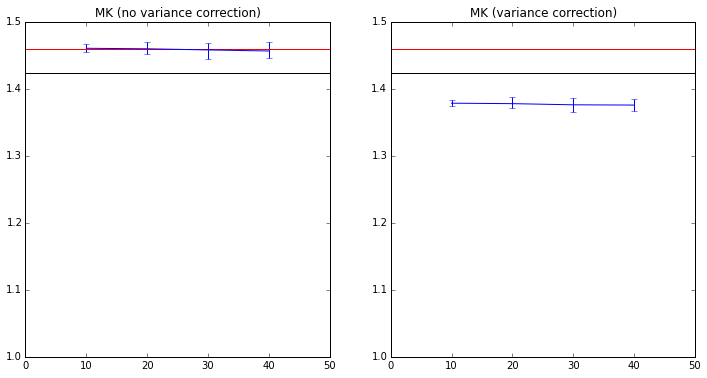

In [10]:
p1, p2, p3 = np.percentile(mk1, [25, 50, 75], axis=1)
mk10 = p2
mk20 = p2 - p1
mk30 = p3 - p2

fig2, ax = plt.subplots(1, 2, figsize=(12, 6))
ax.flat[0].set_title('MK (no variance correction)')
ax.flat[0].plot(np.array([0, 50]), np.mean(DKI_MKgt) * np.ones(2), 'black')
ax.flat[0].plot(np.array([0, 50]), np.mean(DKI_MKgt_rician) * np.ones(2), 'r')
ax.flat[0].errorbar(fsigmas, mk10, yerr=[mk20, mk30])
ax.flat[0].set_ylim([1, 1.5])
ax.flat[0].set_xlim([0, 50])

p1, p2, p3 = np.percentile(mk1c, [25, 50, 75], axis=1)
mk10 = p2
mk20 = p2 - p1
mk30 = p3 - p2

ax.flat[1].set_title('MK (variance correction)')
ax.flat[1].plot(np.array([0, 50]), np.mean(DKI_MKgt) * np.ones(2), 'black')
ax.flat[1].plot(np.array([0, 50]), np.mean(DKI_MKgt_rician) * np.ones(2), 'r')
ax.flat[1].errorbar(fsigmas, mk10, yerr=[mk20, mk30])
ax.flat[1].set_ylim([1, 1.5])
ax.flat[1].set_xlim([0, 50])

In [12]:
p1, p2, p3 = np.percentile(mk1, [25, 50, 75], axis=1)
mk10 = p2
mk20 = p2 - p1
mk30 = p3 - p2
print mk20
print mk30

p1, p2, p3 = np.percentile(mk1c, [25, 50, 75], axis=1)
mk10 = p2
mk20 = p2 - p1
mk30 = p3 - p2
print mk20
print mk30

[ 0.01018542  0.01427855  0.00798093  0.00549123]
[ 0.01267895  0.01011821  0.01017225  0.00617599]
[ 0.00878453  0.01023549  0.00702882  0.0042055 ]
[ 0.00935295  0.01040579  0.00954996  0.00545743]
